# Exploration_17

## Session-Based Recommendation

### 1.1 Module

- 사용할 모듈을 불러옵니다.

In [ ]:
import os
import time
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import datetime as dt
from dateutil import tz
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

### 1.2 Data

#### 1.2.1 Data load

- 구글 드라이브를 마운트합니다.

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


- 사용할 데이터를 불러옵니다.

In [ ]:
train_path = '/gdrive/My Drive/Colab Notebooks/ml-1m/ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['userid', 'itemid', 'rating', 'time']
    return data

data = load_data(train_path, None)
data.sort_values(['time'], inplace=True)  # 시간 순서로 정렬해줍니다.

In [ ]:
data.tail(5)

,userid,itemid,rating,time
825793,4958,2399,1,1046454338
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548
825603,4958,1924,4,1046454590


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 1000138 to 825603
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   userid  1000209 non-null  int32
 1   itemid  1000209 non-null  int32
 2   rating  1000209 non-null  int32
 3   time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


#### 1.2.2 Visualization

In [ ]:
data['userid'].nunique(), data['itemid'].nunique()

(6040, 3706)

- 유저는 6040, 아이템(movies)는 3706개 입니다.

In [ ]:
user_length = data.groupby('userid').size()
user_length

userid
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- userid를 기준으로 groupby해보면 userid 1은 총 53번의 평가를 진행했고 2는 129번 진행했습니다.

In [ ]:
#중앙값, 평균
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

- 평균적으로 165번 평가를 진행했고, 중앙값은 96입니다.

In [ ]:
#최소값, 최댓값
user_length.min(), user_length.max()

(20, 2314)

- 2314번... 평가한 사람은 영화를 정말 좋아하나 봅니다.

In [ ]:
#분위수
user_length.quantile(0.999)

1343.181000000005

In [ ]:
long_session = user_length[user_length == 2314].index[0]
data[data['userid'] == long_session]

,userid,itemid,rating,time
697219,4169,2653,4,965333392
696969,4169,1268,5,965333392
697275,4169,423,3,965333392
697185,4169,2628,4,965333392
697168,4169,2617,4,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


- id 4169번 아저씨군요...

In [ ]:
#하위 99.9% 세션 길이 분포 누적합 시각화
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

- cumsum, 누적합은 하나하나 더해가며 누적시킵니다.
- 누적합에서 전체 합을 나눠주면 0~1까지 순차적으로 분포를 확인할 수 있습니다.  
- 그 중 0.999까지만 받으면 2314번 평가한 사람은 제외됩니다.

Text(0.5, 1.0, 'Cumsum Percentage Until 0.999')

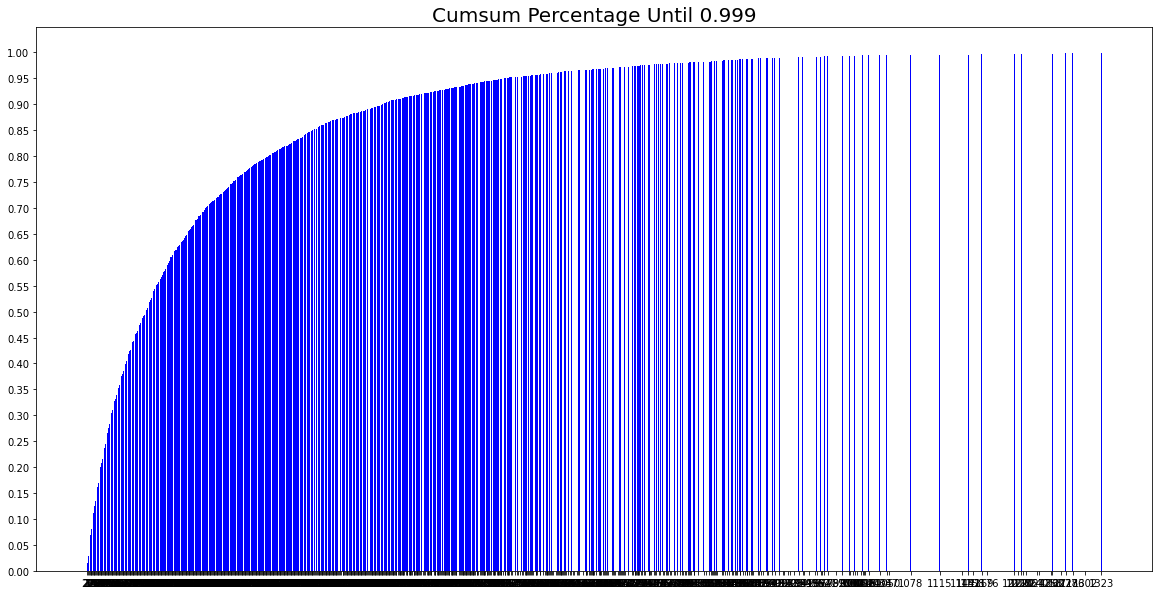

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(x = length_percent_cumsum_999.index, height = length_percent_cumsum_999, color = 'blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)

- 시각화하여 확인해 볼 수 있습니다.
- 사실 user id는 session data가 아닙니다...  
같은 session id를 공유하는 데이터의 클릭 갯수를 세어 시각화를 하는 방법이기 때문입니다만, 안하면 허전해서 해봅니다.  
- 그냥 user가 item(movie)에 대한 rating을 많이 했구나 정도로 생각하고 넘어갑니다.

### 1.3 Preprocess

- 데이터를 확인했으니 preprocess를 진행합니다.
- time column을 온전한 시간으로 바꿔주는 작업을 할 겁니다.

In [ ]:
oldest, latest = data['time'].min(), data['time'].max()
oldest, latest

(956703932, 1046454590)

- time column을 time.gmtime()로 UTC를 찍어봅니다.

In [ ]:
tm_old = time.gmtime(oldest)
print(tm_old)

tm_latest = time.gmtime(latest)
print(tm_latest)

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)
time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)


- 함수로 만들어 time column을 UTC로 변경합니다.

In [ ]:
def timestemp_to_time(x):
    x=pd.to_datetime(time.strftime('%Y-%m-%d %I:%M:%S', time.gmtime(x)))
    return x

In [ ]:
data['time'] = data['time'].apply(timestemp_to_time)
data

,userid,itemid,rating,time
1000138,6040,858,4,2000-04-25 11:05:32
1000153,6040,2384,4,2000-04-25 11:05:54
999873,6040,593,5,2000-04-25 11:05:54
1000007,6040,1961,4,2000-04-25 11:06:17
1000192,6040,2019,5,2000-04-25 11:06:17
...,...,...,...,...
825793,4958,2399,1,2003-02-28 05:45:38
825438,4958,1407,5,2003-02-28 05:47:23
825724,4958,3264,4,2003-02-28 05:49:08
825731,4958,2634,3,2003-02-28 05:49:08


- 데이터를 입맛에 맞게 자를 준비를 합니다.

In [ ]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, short_rate, least_item, unpop_item) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, short_rate)
        data = cleanse_unpopular_item_1(data, least_item)
        data = cleanse_unpopular_item_2(data, unpop_item)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, short_rate):
    session_len = data.groupby('userid').size()
    session_use = session_len[session_len >= short_rate].index
    data = data[data['userid'].isin(session_use)]
    return data


def cleanse_unpopular_item_1(data: pd.DataFrame, least_item):
    item_popular = data.groupby('itemid').size()
    item_use = item_popular[item_popular >= least_item].index
    data = data[data['itemid'].isin(item_use)]
    return data

def cleanse_unpopular_item_2(data: pd.DataFrame, unpop_item):
    item_popular = data.groupby('itemid')['rating'].mean()
    item_use = item_popular[item_popular >= unpop_item].index
    data = data[data['itemid'].isin(item_use)]
    return data

- 리뷰를 남긴 시간이 time으로 남을 뿐 몇분동안 머물면서 리뷰를 남겼는지는 고려 대상이 아닙니다.  
time을 기준으로 user를 제외할 수 없습니다.

- itemid로 size groupby하여 확인해봅니다.
- min 1에 주목해보면, 분명 평가를 1번만 받은 비선호 영화가 있습니다.
- 25%가 33이니 1/4 수준 정도만 잘라내도 좋을 것 같습니다.
- 너무 적게 평가받은 영화를 추천해주는건 도박같은 행위니까요.

In [ ]:
item_a = pd.Series(data.groupby('itemid').size())
item_a.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
dtype: float64

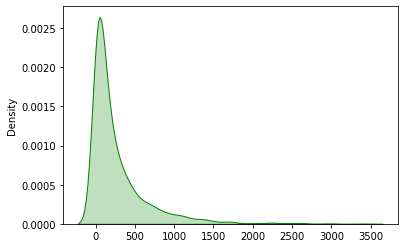

In [ ]:
sns.kdeplot(item_a, shade=True, color='green')

- 이번에는 itemid(movieid)를 rating mean 값으로 groupby 합니다.
- 평균 3.23점대이고 25%는 2.82점까지 입니다.
- 너무 낮은 점수를 받은 영화를 추천해 주는게 맞을까요?  
기준은 사람마다 다르겠지만 저는 rating의 점수대로 잘라주고 싶습니다.

In [ ]:
# sns.countplot('rating', data=data)

In [ ]:
item_b = pd.Series(data.groupby('itemid')['rating'].mean())
item_b.describe()

count    3706.000000
mean        3.238892
std         0.672925
min         1.000000
25%         2.822705
50%         3.331546
75%         3.740741
max         5.000000
Name: rating, dtype: float64

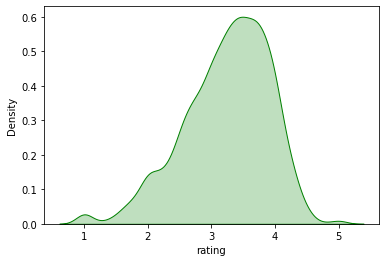

In [ ]:
sns.kdeplot(item_b, shade=True, color='green')

- 자 이제 위에서 만든 cleanse_recursive 함수로 데이터를 깔끔하게 잘라주겠습니다.
- short_rate는 userid의 size가 short한 것을 잘라주겠다는 의미입니다.  
이 데이터에서 userid size가 20 이하인 것은 없습니다...   
1을 넣으나 20을 넣으나 결과값은 동일합니다.  
저는 user의 평가 횟수로 데이터를 자르고 싶은 마음은 없으니 1을 넣고 진행합니다.

- least_item은 평가 횟수로 자르겠다는 의미입니다.  
아까 min값이 1이었던걸 보면 1번 평가 받았는데 5점인 경우도 발생할 수 있습니다.  
저는 20을 기준으로 잘라줍니다.

- unpop은 rating의 mean을 기준으로 자르겠다는 의미입니다.  
쓸데없이 평가가 안 좋은 영화가 추천되는 행위는 눈뜨고 볼 수 없습니다.
3점 이하는 과감하게 자르겠습니다.

In [ ]:
data = cleanse_recursive(data, short_rate=1, least_item=20, unpop_item=3)
data

,userid,itemid,rating,time
1000138,6040,858,4,2000-04-25 11:05:32
1000153,6040,2384,4,2000-04-25 11:05:54
999873,6040,593,5,2000-04-25 11:05:54
1000007,6040,1961,4,2000-04-25 11:06:17
1000192,6040,2019,5,2000-04-25 11:06:17
...,...,...,...,...
825877,4958,2043,1,2003-02-28 05:44:42
825526,4958,3489,4,2003-02-28 05:45:20
825438,4958,1407,5,2003-02-28 05:47:23
825724,4958,3264,4,2003-02-28 05:49:08


- 이 부분은 데이터를 어떻게 보느냐에 대한 관점의 차이입니다만, 딱봐도 이 전처리가 모델의 성능에 큰 영향을 끼칠 것 같습니다...
- 약 15만개의 평가가 잘렸습니다.


### 1.4 Dataset

#### 1.4.1 Dataset

- dataset을 만듭니다.  
00년부터 03년까지 약 3년간의 데이터입니다.  
최근 raing한 데이터가 추천과 관련이 있을 것 같아 기간으로 데이터를 나눠줍니다.

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['time'].max()
    session_last_time = data.groupby('userid')['time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['userid'].isin(session_in_train)]
    after_date = data[data['userid'].isin(session_in_test)]
    after_date = after_date[after_date['itemid'].isin(before_date['itemid'])]
    return before_date, after_date

- 3년이니 6개월을 기준으로 나눠봅니다.  
데이터 수가 적절하지 않으면 다시 돌아와 설정하면 됩니다.

In [ ]:
#test,val을 6달 기준 데이터로 나눔
train, test = split_by_date(data, 180)
train, val = split_by_date(train, 180)

- dataset info도 찍어봅니다.

In [ ]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["userid"].nunique()}\n'
          f'\t Items: {data["itemid"].nunique()}\n'
          f'\t First Time : {data["time"].min()}\n'
          f'\t Last Time : {data["time"].max()}\n')

In [ ]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 694692
	 Sessions: 5554
	 Items: 2155
	 First Time : 2000-04-25 11:05:32
	 Last Time : 2002-03-05 06:30:10

* valid Set Stats Info
	 Events: 44530
	 Sessions: 155
	 Items: 2132
	 First Time : 2000-04-30 06:37:43
	 Last Time : 2002-09-01 12:14:13

* test Set Stats Info
	 Events: 113881
	 Sessions: 331
	 Items: 2151
	 First Time : 2000-04-27 04:38:08
	 Last Time : 2003-02-28 12:51:39



- train을 기준으로 indexing도 진행합니다.

In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['itemid'].unique())}

def indexing(data, id2idx):
    data['item_idx'] = data['itemid'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return data

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

#### 1.4.2 Pipeline

- 데이터를 저장하고, pipeline을 만듭니다.
- user id의 길이 차이가 있으므로 (20~2324) Session-Parallel Mini-Batch의 개념에 따라 배치를 구성합니다.

In [ ]:
data_path = Path('/gdrive/My Drive/Colab Notebooks/ml-1m/processed/') 

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

- userid가 시작되는 인덱스를 담고 새로 indexing한 값을 갖는 클래스입니다.  
session, user id의 차이지 방식은 동일합니다.

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['userid'].nunique())  # indexing to userid

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['userid'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('userid').size().cumsum()
        return offsets

- 뒤에 나오는 클래스에서 일일히 수정하기 싫어서 SessionDataset으로 남겨 놓지만, 다 user id입니다.

In [ ]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,userid,itemid,rating,time,item_idx
1000138,6040,858,4,2000-04-25 11:05:32,0
1000153,6040,2384,4,2000-04-25 11:05:54,1
999873,6040,593,5,2000-04-25 11:05:54,2
1000007,6040,1961,4,2000-04-25 11:06:17,3
1000192,6040,2019,5,2000-04-25 11:06:17,4
999877,6040,1419,3,2000-04-25 11:07:36,5
999920,6040,213,5,2000-04-25 11:07:36,6
999967,6040,3111,5,2000-04-25 11:07:36,7
999868,6040,573,4,2000-04-25 11:07:36,8
999980,6040,3505,4,2000-04-25 11:07:36,9


- 위에서 만든 SessioDataset을 받아서 Mini-Batch를 만듭니다.

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [ ]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,userid,itemid,rating,time,item_idx
1000138,6040,858,4,2000-04-25 11:05:32,0
1000153,6040,2384,4,2000-04-25 11:05:54,1
999873,6040,593,5,2000-04-25 11:05:54,2
1000007,6040,1961,4,2000-04-25 11:06:17,3
1000192,6040,2019,5,2000-04-25 11:06:17,4
999877,6040,1419,3,2000-04-25 11:07:36,5
999920,6040,213,5,2000-04-25 11:07:36,6
999967,6040,3111,5,2000-04-25 11:07:36,7
999868,6040,573,4,2000-04-25 11:07:36,8
999980,6040,3505,4,2000-04-25 11:07:36,9


In [ ]:
iter_ex = iter(train_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  52 170 199]
Label Item Idx are :       [  1  53 171 200]
Previous Masked Input Idx are []


### 1.5 Model

#### 1.5.1 Evaluation

- model을 평가할 MRR, Recall을 만듭니다.

- recall@k는 k개를 추천했을 때 추천되어야 하는 relevant한 아이템이 몇개나 있는지를 확인하기 위한 지표입니다.

- MRR@k은 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표입니다.  
하지만 그대로 몇 번째인지를 사용하면 앞에 나올 수록 좋은 모델이라는 것을 반대로 표현하게되니 역수를 이용합니다.

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### 1.5.2 Model Architecture

- 모델의 구조를 구현합니다.

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=(args.optimizer), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, train, val, test, batch_size, hsz, drop_rate, optimizer, epochs, k):
        self.train = train
        self.val = val
        self.test = test
        self.num_items = train['itemid'].nunique()
        self.num_sessions = train['userid'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.optimizer = optimizer
        self.epochs = epochs
        self.k = k

In [ ]:
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['itemid'].nunique()
        train_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in train_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            train_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print('=')
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['itemid'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 1.6 Training

- 이번에도 model의 hyper parameter를 바꿔가며 비교해봅니다.
- 결과적으로 거의 모든 모델의 Recall@20, MRR@20 값이 특정 값으로 수렴하는데,  
모델 하나당 대략적으로 40분의 학습 시간이 필요합니다.  
어떤 hyper parameter가 학습 시간에 효율적일지 확인해봅니다.

#### 1.6.1 Default_Model

- 뒤에 나올 모델의 default 값이 될 모델입니다.

##### 1) model_1(batch 64, units 50, Adam, lr 0.001)

- batch size는 64, gru의 units은 50, drop rate는 0.1  
optimizer는 Adam에 learning rate는 0.001, epochs 10, k 20 입니다.

In [ ]:
args = Args(train, val, test, batch_size=64, hsz=50, drop_rate=0.1, optimizer=Adam(0.001), epochs=10, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(64, 1, 2155)]           0         
                                                                 
 GRU (GRU)                   [(64, 50),                331050    
                              (64, 50)]                          
                                                                 
 dropout_2 (Dropout)         (64, 50)                  0         
                                                                 
 dense_2 (Dense)             (64, 2155)                109905    
                                                                 
Total params: 440,955
Trainable params: 440,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, args)

Evaluation:  75%|███████▍  | 496/662 [07:07<02:23,  1.16it/s]


	 - Recall@20 epoch 1: 0.180318
	 - MRR@20    epoch 1: 0.039636



Evaluation:  75%|███████▍  | 496/662 [06:58<02:20,  1.18it/s]


	 - Recall@20 epoch 2: 0.218151
	 - MRR@20    epoch 2: 0.049180



Evaluation:  75%|███████▍  | 496/662 [06:57<02:19,  1.19it/s]


	 - Recall@20 epoch 3: 0.229870
	 - MRR@20    epoch 3: 0.053533



Evaluation:  75%|███████▍  | 496/662 [06:52<02:18,  1.20it/s]


	 - Recall@20 epoch 4: 0.236328
	 - MRR@20    epoch 4: 0.055777



Evaluation:  75%|███████▍  | 496/662 [06:52<02:17,  1.20it/s]


	 - Recall@20 epoch 5: 0.239132
	 - MRR@20    epoch 5: 0.057992



Evaluation:  75%|███████▍  | 496/662 [06:51<02:17,  1.21it/s]


	 - Recall@20 epoch 6: 0.241872
	 - MRR@20    epoch 6: 0.058980



Evaluation:  75%|███████▍  | 496/662 [06:45<02:15,  1.22it/s]


	 - Recall@20 epoch 7: 0.242503
	 - MRR@20    epoch 7: 0.058993



Evaluation:  75%|███████▍  | 496/662 [06:46<02:16,  1.22it/s]


	 - Recall@20 epoch 8: 0.242471
	 - MRR@20    epoch 8: 0.059456



Evaluation:  75%|███████▍  | 496/662 [06:47<02:16,  1.22it/s]


	 - Recall@20 epoch 9: 0.242314
	 - MRR@20    epoch 9: 0.059636



Evaluation:  75%|███████▍  | 496/662 [06:45<02:15,  1.22it/s]

	 - Recall@20 epoch 10: 0.240864
	 - MRR@20    epoch 10: 0.059519



In [ ]:
test_model(model, args, test)

Evaluation:  87%|████████▋ | 1522/1745 [21:01<03:04,  1.21it/s]

	 - Recall@20: 0.239724
	 - MRR@20: 0.059894



#### 1.6.2 Batch_Size

- 다른 모든 조건은 동일하고 batch size에 따른 학습 속도를 살펴봅니다.

##### 1) model_2(batch 128, units 50, Adam, lr 0.001)

In [ ]:
args_2 = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, optimizer=Adam(0.001), epochs=10, k=20)
model_2 = create_model(args_2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               331050    
                              (128, 50)]                         
                                                                 
 dropout_1 (Dropout)         (128, 50)                 0         
                                                                 
 dense_1 (Dense)             (128, 2155)               109905    
                                                                 
Total params: 440,955
Trainable params: 440,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_2, args_2)

Evaluation:  31%|███       | 102/331 [03:01<06:48,  1.78s/it]


=*20
	 - Recall@20 epoch 1: 0.156173
	 - MRR@20    epoch 1: 0.035486



Evaluation:  31%|███       | 102/331 [02:47<06:16,  1.64s/it]


=*20
	 - Recall@20 epoch 2: 0.210861
	 - MRR@20    epoch 2: 0.048361



Evaluation:  31%|███       | 102/331 [02:45<06:10,  1.62s/it]


=*20
	 - Recall@20 epoch 3: 0.229013
	 - MRR@20    epoch 3: 0.053430



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 4: 0.235830
	 - MRR@20    epoch 4: 0.055424



Evaluation:  31%|███       | 102/331 [02:42<06:05,  1.60s/it]


=*20
	 - Recall@20 epoch 5: 0.239583
	 - MRR@20    epoch 5: 0.057268



Evaluation:  31%|███       | 102/331 [02:43<06:06,  1.60s/it]


=*20
	 - Recall@20 epoch 6: 0.239200
	 - MRR@20    epoch 6: 0.058501



Evaluation:  31%|███       | 102/331 [02:42<06:04,  1.59s/it]


=*20
	 - Recall@20 epoch 7: 0.241651
	 - MRR@20    epoch 7: 0.058935



Evaluation:  31%|███       | 102/331 [02:41<06:03,  1.59s/it]


=*20
	 - Recall@20 epoch 8: 0.240656
	 - MRR@20    epoch 8: 0.059385



Evaluation:  31%|███       | 102/331 [02:42<06:05,  1.60s/it]


=*20
	 - Recall@20 epoch 9: 0.239047
	 - MRR@20    epoch 9: 0.058650



Evaluation:  31%|███       | 102/331 [02:42<06:05,  1.60s/it]

=*20
	 - Recall@20 epoch 10: 0.238894
	 - MRR@20    epoch 10: 0.059124



In [ ]:
test_model(model_2, args_2, test)

Evaluation:  73%|███████▎  | 633/872 [16:44<06:19,  1.59s/it]

	 - Recall@20: 0.251098
	 - MRR@20: 0.061699



##### 2) model_3(batch 32, units 50, Adam, lr 0.001)

In [ ]:
args_3 = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, optimizer=Adam(0.001), epochs=10, k=20)
model_3 = create_model(args_3)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(32, 1, 2155)]           0         
                                                                 
 GRU (GRU)                   [(32, 50),                331050    
                              (32, 50)]                          
                                                                 
 dropout_4 (Dropout)         (32, 50)                  0         
                                                                 
 dense_4 (Dense)             (32, 2155)                109905    
                                                                 
Total params: 440,955
Trainable params: 440,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_3, args_3)

Evaluation:  91%|█████████ | 1202/1324 [08:58<00:54,  2.23it/s]


=*20
	 - Recall@20 epoch 1: 0.199823
	 - MRR@20    epoch 1: 0.045467



Evaluation:  91%|█████████ | 1202/1324 [08:48<00:53,  2.27it/s]


=*20
	 - Recall@20 epoch 2: 0.225224
	 - MRR@20    epoch 2: 0.052607



Evaluation:  91%|█████████ | 1202/1324 [08:45<00:53,  2.29it/s]


=*20
	 - Recall@20 epoch 3: 0.234583
	 - MRR@20    epoch 3: 0.056167



Evaluation:  91%|█████████ | 1202/1324 [08:46<00:53,  2.28it/s]


=*20
	 - Recall@20 epoch 4: 0.236507
	 - MRR@20    epoch 4: 0.058122



Evaluation:  91%|█████████ | 1202/1324 [08:44<00:53,  2.29it/s]


=*20
	 - Recall@20 epoch 5: 0.239393
	 - MRR@20    epoch 5: 0.059406



Evaluation:  91%|█████████ | 1202/1324 [08:44<00:53,  2.29it/s]


=*20
	 - Recall@20 epoch 6: 0.238977
	 - MRR@20    epoch 6: 0.059729



Evaluation:  91%|█████████ | 1202/1324 [08:45<00:53,  2.29it/s]


=*20
	 - Recall@20 epoch 7: 0.238665
	 - MRR@20    epoch 7: 0.059817



Evaluation:  91%|█████████ | 1202/1324 [08:46<00:53,  2.28it/s]


=*20
	 - Recall@20 epoch 8: 0.237235
	 - MRR@20    epoch 8: 0.059207



Evaluation:  91%|█████████ | 1202/1324 [09:15<00:56,  2.17it/s]


=*20
	 - Recall@20 epoch 9: 0.236143
	 - MRR@20    epoch 9: 0.059449



Evaluation:  91%|█████████ | 1202/1324 [08:50<00:53,  2.27it/s]

=*20
	 - Recall@20 epoch 10: 0.235545
	 - MRR@20    epoch 10: 0.059156



In [ ]:
test_model(model_3, args_3, test)

Evaluation:  95%|█████████▍| 3312/3491 [24:13<01:18,  2.28it/s]

	 - Recall@20: 0.229572
	 - MRR@20: 0.057527



##### 3) Compare

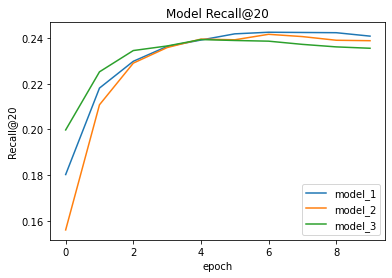

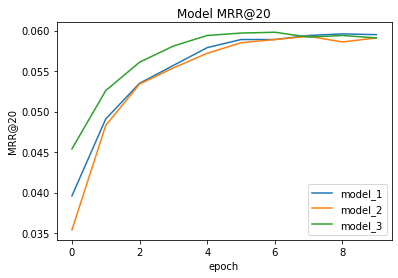

In [ ]:
plt.plot(model_recall_1)
plt.plot(model_recall_2)
plt.plot(model_recall_3)
plt.title('Model Recall@20')
plt.ylabel('Recall@20')
plt.xlabel('epoch')
plt.legend(['model_1', 'model_2', 'model_3'], loc='lower right')
plt.show()

plt.plot(model_mrr_1)
plt.plot(model_mrr_2)
plt.plot(model_mrr_3)
plt.title('Model MRR@20')
plt.ylabel('MRR@20')
plt.xlabel('epoch')
plt.legend(['model_1', 'model_2', 'model_3'], loc='lower right')
plt.show()

- 어차피 모델은 어느 정도 비슷한 성능으로 값이 수렴합니다.  
속도만 놓고 보면 당연히 batch size가 큰 쪽이 빠릅니다.
- 시간이 많다면 작은 batch size로 epochs를 많이 늘려서 시도하는 것도 나쁘지 않을 것 같습니다.

#### 1.6.3 Learning_Rate

- 이번에는 Learning_rate만 변화를 줍니다.  
- 시간관계상 batch 128 모델을 기준으로 돌립니다.

##### 1) model_4(batch 128, units 50, Adam, lr 0.005)

In [ ]:
args_4 = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, optimizer=Adam(0.005), epochs=10, k=20)
model_4 = create_model(args_4)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               331050    
                              (128, 50)]                         
                                                                 
 dropout_7 (Dropout)         (128, 50)                 0         
                                                                 
 dense_7 (Dense)             (128, 2155)               109905    
                                                                 
Total params: 440,955
Trainable params: 440,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_4, args_4)

Evaluation:  31%|███       | 102/331 [02:46<06:14,  1.64s/it]


=*20
	 - Recall@20 epoch 1: 0.226486
	 - MRR@20    epoch 1: 0.054730



Evaluation:  31%|███       | 102/331 [02:45<06:12,  1.63s/it]


=*20
	 - Recall@20 epoch 2: 0.236290
	 - MRR@20    epoch 2: 0.059677



Evaluation:  31%|███       | 102/331 [02:45<06:12,  1.63s/it]


=*20
	 - Recall@20 epoch 3: 0.234375
	 - MRR@20    epoch 3: 0.059038



Evaluation:  31%|███       | 102/331 [02:47<06:15,  1.64s/it]


=*20
	 - Recall@20 epoch 4: 0.235907
	 - MRR@20    epoch 4: 0.058250



Evaluation:  31%|███       | 102/331 [02:46<06:13,  1.63s/it]


=*20
	 - Recall@20 epoch 5: 0.230239
	 - MRR@20    epoch 5: 0.058458



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]


=*20
	 - Recall@20 epoch 6: 0.230162
	 - MRR@20    epoch 6: 0.058057



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.61s/it]


=*20
	 - Recall@20 epoch 7: 0.226333
	 - MRR@20    epoch 7: 0.057885



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.61s/it]


=*20
	 - Recall@20 epoch 8: 0.225797
	 - MRR@20    epoch 8: 0.057532



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 9: 0.224418
	 - MRR@20    epoch 9: 0.056623



Evaluation:  31%|███       | 102/331 [02:44<06:09,  1.61s/it]

=*20
	 - Recall@20 epoch 10: 0.224494
	 - MRR@20    epoch 10: 0.056369



In [ ]:
test_model(model_4, args_4, test)

Evaluation:  73%|███████▎  | 633/872 [16:53<06:22,  1.60s/it]

	 - Recall@20: 0.233499
	 - MRR@20: 0.057398



##### 2) model_5(batch 128, units 50, Adam, lr 0.0005)

In [ ]:
args_5 = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, optimizer=Adam(0.0005), epochs=10, k=20)
model_5 = create_model(args_5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               331050    
                              (128, 50)]                         
                                                                 
 dropout_8 (Dropout)         (128, 50)                 0         
                                                                 
 dense_8 (Dense)             (128, 2155)               109905    
                                                                 
Total params: 440,955
Trainable params: 440,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_5, args_5)

Evaluation:  31%|███       | 102/331 [02:58<06:41,  1.75s/it]


=*20
	 - Recall@20 epoch 1: 0.067172
	 - MRR@20    epoch 1: 0.013536



Evaluation:  31%|███       | 102/331 [02:51<06:24,  1.68s/it]


=*20
	 - Recall@20 epoch 2: 0.151654
	 - MRR@20    epoch 2: 0.034329



Evaluation:  31%|███       | 102/331 [02:47<06:15,  1.64s/it]


=*20
	 - Recall@20 epoch 3: 0.194623
	 - MRR@20    epoch 3: 0.045706



Evaluation:  31%|███       | 102/331 [02:45<06:12,  1.63s/it]


=*20
	 - Recall@20 epoch 4: 0.214231
	 - MRR@20    epoch 4: 0.049576



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 5: 0.224265
	 - MRR@20    epoch 5: 0.052303



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 6: 0.229550
	 - MRR@20    epoch 6: 0.053435



Evaluation:  31%|███       | 102/331 [02:44<06:09,  1.61s/it]


=*20
	 - Recall@20 epoch 7: 0.236213
	 - MRR@20    epoch 7: 0.054251



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.61s/it]


=*20
	 - Recall@20 epoch 8: 0.237515
	 - MRR@20    epoch 8: 0.055240



Evaluation:  31%|███       | 102/331 [02:44<06:09,  1.61s/it]


=*20
	 - Recall@20 epoch 9: 0.239200
	 - MRR@20    epoch 9: 0.056999



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]

=*20
	 - Recall@20 epoch 10: 0.240656
	 - MRR@20    epoch 10: 0.058284



In [ ]:
test_model(model_5, args_5, test)

Evaluation:  73%|███████▎  | 633/872 [16:46<06:19,  1.59s/it]

	 - Recall@20: 0.251753
	 - MRR@20: 0.060254



##### 3) Compare

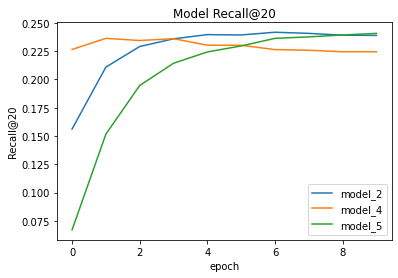

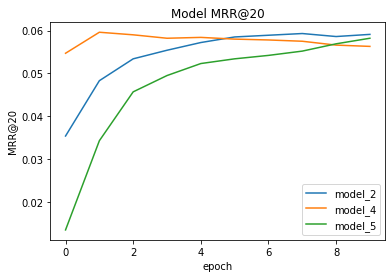

In [ ]:
plt.plot(model_recall_2)
plt.plot(model_recall_4)
plt.plot(model_recall_5)
plt.title('Model Recall@20')
plt.ylabel('Recall@20')
plt.xlabel('epoch')
plt.legend(['model_2', 'model_4', 'model_5'], loc='lower right')
plt.show()

plt.plot(model_mrr_2)
plt.plot(model_mrr_4)
plt.plot(model_mrr_5)
plt.title('Model MRR@20')
plt.ylabel('MRR@20')
plt.xlabel('epoch')
plt.legend(['model_2', 'model_4', 'model_5'], loc='lower right')
plt.show()

- 예상한 결과입니다.  
- 시간을 고려하면 default인 0.001이 적당합니다만,  0.0005의 변화율을 봤을 때 더 많은 epochs로 학습하는 것도 좋아보입니다.

#### 1.6.4 Units

- 이번에는 GRU 모델의 Units에 변화를 줬습니다.  
당연히 model의 output와 total params의 갯수의 차이가 있을겁니다.  
- 이번에도 시간관계상 batch 128을 기준으로 돌렸습니다.

##### 1) model_6(batch 128, units 20, Adam, lr 0.001)

In [ ]:
args_6 = Args(train, val, test, batch_size=128, hsz=20, drop_rate=0.1, optimizer=Adam(0.001), epochs=10, k=20)
model_6 = create_model(args_6)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 20),               130620    
                              (128, 20)]                         
                                                                 
 dropout_9 (Dropout)         (128, 20)                 0         
                                                                 
 dense_9 (Dense)             (128, 2155)               45255     
                                                                 
Total params: 175,875
Trainable params: 175,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_6, args_6)

Evaluation:  31%|███       | 102/331 [02:56<06:36,  1.73s/it]


=*20
	 - Recall@20 epoch 1: 0.075597
	 - MRR@20    epoch 1: 0.014760



Evaluation:  31%|███       | 102/331 [02:49<06:20,  1.66s/it]


=*20
	 - Recall@20 epoch 2: 0.155484
	 - MRR@20    epoch 2: 0.034518



Evaluation:  31%|███       | 102/331 [02:46<06:12,  1.63s/it]


=*20
	 - Recall@20 epoch 3: 0.193015
	 - MRR@20    epoch 3: 0.043907



Evaluation:  31%|███       | 102/331 [02:46<06:14,  1.63s/it]


=*20
	 - Recall@20 epoch 4: 0.207721
	 - MRR@20    epoch 4: 0.047492



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]


=*20
	 - Recall@20 epoch 5: 0.217754
	 - MRR@20    epoch 5: 0.049658



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]


=*20
	 - Recall@20 epoch 6: 0.220971
	 - MRR@20    epoch 6: 0.051720



Evaluation:  31%|███       | 102/331 [02:45<06:12,  1.62s/it]


=*20
	 - Recall@20 epoch 7: 0.224341
	 - MRR@20    epoch 7: 0.052337



Evaluation:  31%|███       | 102/331 [02:46<06:13,  1.63s/it]


=*20
	 - Recall@20 epoch 8: 0.227175
	 - MRR@20    epoch 8: 0.052932



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]


=*20
	 - Recall@20 epoch 9: 0.231388
	 - MRR@20    epoch 9: 0.053894



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]

=*20
	 - Recall@20 epoch 10: 0.230928
	 - MRR@20    epoch 10: 0.054021



In [ ]:
test_model(model_6, args_6, test)

Evaluation:  73%|███████▎  | 633/872 [17:00<06:25,  1.61s/it]

	 - Recall@20: 0.238473
	 - MRR@20: 0.055484



##### 2) model_7(batch 128, units 100, Adam, lr 0.001)

In [ ]:
args_7 = Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, optimizer=Adam(0.001), epochs=10, k=20)
model_7 = create_model(args_7)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 100),              677100    
                              (128, 100)]                        
                                                                 
 dropout_10 (Dropout)        (128, 100)                0         
                                                                 
 dense_10 (Dense)            (128, 2155)               217655    
                                                                 
Total params: 894,755
Trainable params: 894,755
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_7, args_7)

Evaluation:  31%|███       | 102/331 [02:50<06:23,  1.67s/it]


=*20
	 - Recall@20 epoch 1: 0.190870
	 - MRR@20    epoch 1: 0.044498



Evaluation:  31%|███       | 102/331 [02:46<06:13,  1.63s/it]


=*20
	 - Recall@20 epoch 2: 0.225567
	 - MRR@20    epoch 2: 0.052763



Evaluation:  31%|███       | 102/331 [02:45<06:10,  1.62s/it]


=*20
	 - Recall@20 epoch 3: 0.235754
	 - MRR@20    epoch 3: 0.057187



Evaluation:  31%|███       | 102/331 [02:44<06:09,  1.61s/it]


=*20
	 - Recall@20 epoch 4: 0.237898
	 - MRR@20    epoch 4: 0.059704



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 5: 0.240349
	 - MRR@20    epoch 5: 0.061045



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.60s/it]


=*20
	 - Recall@20 epoch 6: 0.243336
	 - MRR@20    epoch 6: 0.061815



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.61s/it]


=*20
	 - Recall@20 epoch 7: 0.242188
	 - MRR@20    epoch 7: 0.061562



Evaluation:  31%|███       | 102/331 [02:43<06:06,  1.60s/it]


=*20
	 - Recall@20 epoch 8: 0.240656
	 - MRR@20    epoch 8: 0.061244



Evaluation:  31%|███       | 102/331 [02:43<06:08,  1.61s/it]


=*20
	 - Recall@20 epoch 9: 0.237669
	 - MRR@20    epoch 9: 0.061150



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.60s/it]

=*20
	 - Recall@20 epoch 10: 0.237209
	 - MRR@20    epoch 10: 0.060325



In [ ]:
test_model(model_7, args_7, test)

Evaluation:  73%|███████▎  | 633/872 [16:48<06:20,  1.59s/it]

	 - Recall@20: 0.248531
	 - MRR@20: 0.062684



##### 3) Compare

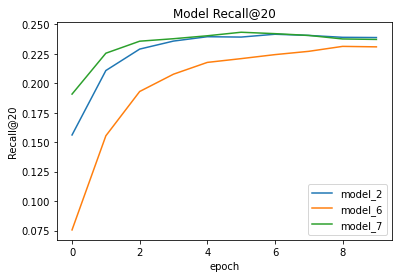

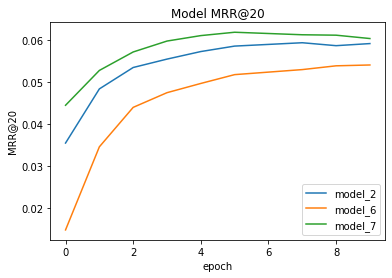

In [ ]:
plt.plot(model_recall_2)
plt.plot(model_recall_6)
plt.plot(model_recall_7)
plt.title('Model Recall@20')
plt.ylabel('Recall@20')
plt.xlabel('epoch')
plt.legend(['model_2', 'model_6', 'model_7'], loc='lower right')
plt.show()

plt.plot(model_mrr_2)
plt.plot(model_mrr_6)
plt.plot(model_mrr_7)
plt.title('Model MRR@20')
plt.ylabel('MRR@20')
plt.xlabel('epoch')
plt.legend(['model_2', 'model_6', 'model_7'], loc='lower right')
plt.show()

- unit의 수가 너무 낮으면 모델의 성능이 좋지 못합니다.
- 너무 높아도 큰 의미가 없다는 것도 확인할 수 있습니다.

#### 1.6.5 Optimizer

- 이번에는 제가 제일 좋아하는 optimizer에 변화를 줍니다.
- 마찬가지로 시간관계상 batch 128을 기준으로 돌립니다.

##### 1) model_8(batch 128, units 100, Nadam, lr 0.0005)

In [ ]:
args_8 = Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, optimizer=Nadam(0.0005), epochs=10, k=20)
model_8 = create_model(args_8)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 100),              677100    
                              (128, 100)]                        
                                                                 
 dropout (Dropout)           (128, 100)                0         
                                                                 
 dense (Dense)               (128, 2155)               217655    
                                                                 
Total params: 894,755
Trainable params: 894,755
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_8, args_8)

Evaluation:  31%|███       | 102/331 [02:58<06:41,  1.75s/it]


=
	 - Recall@20 epoch 1: 0.123545
	 - MRR@20    epoch 1: 0.027775



Evaluation:  31%|███       | 102/331 [02:50<06:22,  1.67s/it]


=
	 - Recall@20 epoch 2: 0.196002
	 - MRR@20    epoch 2: 0.045607



Evaluation:  31%|███       | 102/331 [02:46<06:14,  1.63s/it]


=
	 - Recall@20 epoch 3: 0.221278
	 - MRR@20    epoch 3: 0.052273



Evaluation:  31%|███       | 102/331 [02:45<06:11,  1.62s/it]


=
	 - Recall@20 epoch 4: 0.233839
	 - MRR@20    epoch 4: 0.055834



Evaluation:  31%|███       | 102/331 [02:43<06:06,  1.60s/it]


=
	 - Recall@20 epoch 5: 0.237745
	 - MRR@20    epoch 5: 0.058064



Evaluation:  31%|███       | 102/331 [02:44<06:08,  1.61s/it]


=
	 - Recall@20 epoch 6: 0.243490
	 - MRR@20    epoch 6: 0.059528



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.60s/it]


=
	 - Recall@20 epoch 7: 0.243490
	 - MRR@20    epoch 7: 0.060953



Evaluation:  31%|███       | 102/331 [02:43<06:07,  1.61s/it]


=
	 - Recall@20 epoch 8: 0.244332
	 - MRR@20    epoch 8: 0.061242



Evaluation:  31%|███       | 102/331 [02:43<06:06,  1.60s/it]


=
	 - Recall@20 epoch 9: 0.244409
	 - MRR@20    epoch 9: 0.062102



Evaluation:  31%|███       | 102/331 [02:42<06:04,  1.59s/it]

=
	 - Recall@20 epoch 10: 0.244715
	 - MRR@20    epoch 10: 0.062387



In [ ]:
test_model(model_8, args_8, test)

Evaluation:  73%|███████▎  | 633/872 [17:19<06:32,  1.64s/it]

	 - Recall@20: 0.253184
	 - MRR@20: 0.063782



##### 2) model_9(batch 128, units 100, RMSprop, lr 0.0005)

In [ ]:
args_9 = Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, optimizer=RMSprop(0.0005), epochs=10, k=20)
model_9 = create_model(args_9)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(128, 1, 2155)]          0         
                                                                 
 GRU (GRU)                   [(128, 100),              677100    
                              (128, 100)]                        
                                                                 
 dropout_1 (Dropout)         (128, 100)                0         
                                                                 
 dense_1 (Dense)             (128, 2155)               217655    
                                                                 
Total params: 894,755
Trainable params: 894,755
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model_9, args_9)

Evaluation:  31%|███       | 102/331 [03:09<07:06,  1.86s/it]


=
	 - Recall@20 epoch 1: 0.079197
	 - MRR@20    epoch 1: 0.016626



Evaluation:  31%|███       | 102/331 [02:55<06:33,  1.72s/it]


=
	 - Recall@20 epoch 2: 0.122396
	 - MRR@20    epoch 2: 0.027231



Evaluation:  31%|███       | 102/331 [03:02<06:49,  1.79s/it]


=
	 - Recall@20 epoch 3: 0.147901
	 - MRR@20    epoch 3: 0.034684



Evaluation:  31%|███       | 102/331 [02:55<06:34,  1.72s/it]


=
	 - Recall@20 epoch 4: 0.167433
	 - MRR@20    epoch 4: 0.039437



Evaluation:  31%|███       | 102/331 [03:01<06:47,  1.78s/it]


=
	 - Recall@20 epoch 5: 0.170190
	 - MRR@20    epoch 5: 0.039383



Evaluation:  31%|███       | 102/331 [02:51<06:23,  1.68s/it]


=
	 - Recall@20 epoch 6: 0.180913
	 - MRR@20    epoch 6: 0.041973



Evaluation:  31%|███       | 102/331 [02:51<06:26,  1.69s/it]


=
	 - Recall@20 epoch 7: 0.183670
	 - MRR@20    epoch 7: 0.043208



Evaluation:  31%|███       | 102/331 [02:52<06:28,  1.69s/it]


=
	 - Recall@20 epoch 8: 0.186887
	 - MRR@20    epoch 8: 0.044635



Evaluation:  31%|███       | 102/331 [02:50<06:22,  1.67s/it]


=
	 - Recall@20 epoch 9: 0.188343
	 - MRR@20    epoch 9: 0.044729



Evaluation:  31%|███       | 102/331 [02:49<06:21,  1.66s/it]

=
	 - Recall@20 epoch 10: 0.190640
	 - MRR@20    epoch 10: 0.045282



In [ ]:
test_model(model_9, args_9, test)

Evaluation:  73%|███████▎  | 633/872 [17:42<06:41,  1.68s/it]

	 - Recall@20: 0.199163
	 - MRR@20: 0.048002



##### 3) Compare

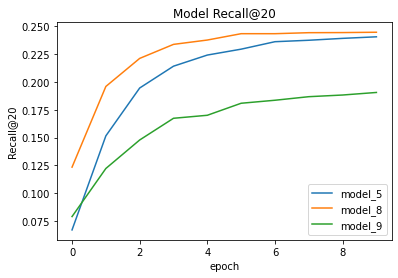

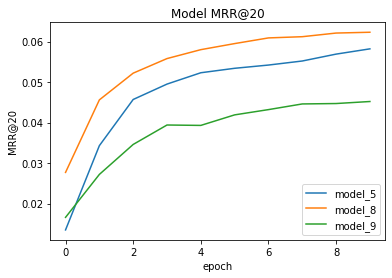

In [ ]:
plt.plot(model_recall_5)
plt.plot(model_recall_8)
plt.plot(model_recall_9)
plt.title('Model Recall@20')
plt.ylabel('Recall@20')
plt.xlabel('epoch')
plt.legend(['model_5', 'model_8', 'model_9'], loc='lower right')
plt.show()

plt.plot(model_mrr_5)
plt.plot(model_mrr_8)
plt.plot(model_mrr_9)
plt.title('Model MRR@20')
plt.ylabel('MRR@20')
plt.xlabel('epoch')
plt.legend(['model_5', 'model_8', 'model_9'], loc='lower right')
plt.show()

- RMSprop은 이번에는 적절하지 못한 Optimizer인 것 같습니다.  
- Nadam이 Adam보다 목표값에 더 빨리 도달하는 모습을 보입니다.

### 1.7 Conclusion

#### 1.7.1 Recall

- testset으로 돌린 모델에서 recall 값이 가장 좋은 모델은 model_8입니다.  
(batch_size=128, hsz=100, drop_rate=0.1, optimizer=Nadam(0.0005), epochs=10, k=20)

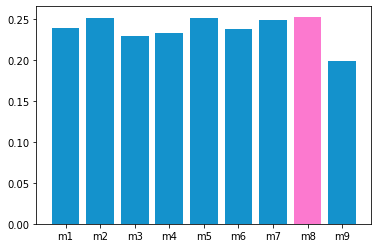

In [ ]:
plt.bar(x, model_recall_test, color=colors)
plt.xticks(x, model_label)
plt.show()

#### 1.7.2 MRR

- 마찬가지로 MRR 값이 가장 좋은 모델은 model_8입니다.  
(batch_size=128, hsz=100, drop_rate=0.1, optimizer=Nadam(0.0005), epochs=10, k=20)

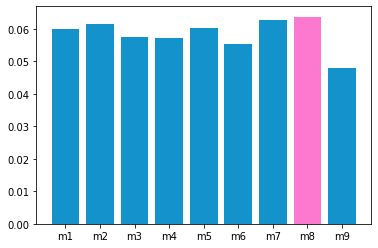

In [ ]:
plt.bar(x, model_mrr_test, color=colors)
plt.xticks(x, model_label)
plt.show()

## 2. Retrospect

##### 1) Preprocess
- 이번 전처리는 user_id에 대한 전처리입니다.  
그냥 session 전처리와 동일하게 하면 안 된다고 생각했는데, user_id는 클릭에 따른 session이 아니기 때문입니다.  
그리고 말 그대로 '추천'입니다. rating이 높은 영화를 추천하는 것이 좋다고 판단하여 rating mean 3 이상만 잡았습니다.  
이 부분도 평균이 아닌 그냥 rating > 3으로 자르면 일부 garbage 영화가 섞여 들어갈 수 있다고 생각됩니다.  
간혹 인도영화 같은 경우에 그런 경우가 있는데 rating 받은 횟수가 적고 편파적이어서 rating mean 값이 매우 높은 경우를 대비해 최소 rating size(item_id)를 잡아서 잘라주는 것도 필요하다고 생각합니다.  
이번 task에서는 전처리가 절반 이상입니다.

##### 2) Hyper Parameter
- 이미 전처리 단계에서 모델의 Recall, MRR 값은 어느 정도 정해진다고 생각합니다.  
그런데도 하이퍼 파라미터값을 변경하며 모델을 비교한 이유는 속도입니다.
모델 하나에 평균 40분가량 소요되고 testset 모델도 20분 정도 걸립니다.
어떤 하이퍼 파라미터를 건드려야 모든 모델이 향하는 '그 값'에 빠르게 도달할지가 궁금했습니다.  
덤으로 성능도 좋아야겠지요. epochs를 10 이상으로 늘리지 않는다는 전제하에 batch는 128, unit은 100, optimizer는 Nadam, learning rate는 0.001이면 충분합니다. 이 정도면 epochs 4로도 충분해 보입니다.

##### 3) Data
- 최신 영화까지 다룬 1GB가 넘어가는 데이터가 있지만, 시간 관계상 사용하지 못해 매우 아쉽습니다.  
이 부분은 여유가 생길 때 다시 진행해보려 합니다
항상 느끼지만, 데이터는 많으면 많을수록 재미있습니다.

##### 4) Epochs
- learning rate를 작게 주고 train 했을 때 비집고 들어갈 틈이 보인다는 느낌을 받았습니다만,  
시간이 너무 부족합니다. drop rate도 조금 높이고 epochs를 넉넉히 주어 돌리고 싶습니다.  
물론 최신 movielens data를 이용해서 돌려야 의미가 있을 겁니다.


## 3. References

- 아래의 사이트에서 많은 도움을 받았습니다.

##### 1) GRU
- https://keras.io/api/layers/recurrent_layers/gru/
- https://hyen4110.tistory.com/26
- https://velog.io/@dong970827/RNN-LSTM-GRU-%EA%B0%9C%EB%85%90

##### 2) Optimizer
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://keras.io/api/optimizers/
- https://keras.io/api/optimizers/Nadam/

##### 3) Evaluation Metrix
- https://ang-love-chang.tistory.com/22
- https://zzaebok.github.io/recommender_system/metrics/rec_metrics/
- https://lamttic.github.io/2020/03/20/01.html